# Helpful Functions

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D


Using TensorFlow backend.


In [3]:
# Read MFCCs feature CSV file of audio of 100ms block

path="/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/training"
#filename=os.path.join(path,"100ms_7C.csv")
df=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/training/final_250ms.csv", na_values=['NA','?'])
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 
            'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
#df=pd.read_csv(filename,na_values=['NA','?'])
filename_write = os.path.join(path,"/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/training/output_cnnkfold_250ms.csv")
print(df.shape)
df.head()

(1151855, 14)


,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-1.156698,30.177571,14.660770,3.607221,0.288360,2.769165,-3.234655,6.639185,-1.344169,4.468443,-2.958039,2.068470,1.180088,AC & FAN
1,-1.057954,30.020239,14.655350,4.016522,0.670491,2.716826,-2.725660,6.585149,-0.531257,5.018496,-1.769480,2.426556,1.197883,AC & FAN
2,-1.038729,30.297200,14.477445,4.185600,-0.013551,2.507586,-2.385098,7.583516,0.821473,5.668451,-2.216360,1.834316,0.287000,AC & FAN
3,-1.031753,30.308872,14.390459,4.556633,-0.998314,2.591629,-2.220589,7.024910,-0.051632,5.291946,-1.373251,1.892320,0.522117,AC & FAN
4,-1.008919,30.663115,14.199688,3.618487,-2.098603,1.240299,-3.486570,8.769523,1.134318,5.685237,-0.009215,2.604023,0.304691,AC & FAN


In [4]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [5]:
df=df.dropna()
df.shape

(1151855, 14)

In [6]:
print("Label has na? {}".format(pd.isnull(df['Label']).values.any()))

Label has na? False


In [7]:
# Shuffle
np.random.seed(42)# set a seed so that the results are consistent
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-2.258577,-15.339601,-2.788815,-25.249022,-30.498448,-23.184589,-6.682635,-2.963845,-29.011377,-6.843955,-6.695362,15.474780,7.171197,CRYING
1,3.573552,-29.801286,-32.800348,18.600491,-18.167120,0.516414,8.259454,-13.633365,-6.569277,9.981354,36.312308,14.698279,-5.105866,CRYING
2,-0.516653,45.215485,8.872781,3.358796,2.520323,-5.653455,0.178937,0.699667,-1.335385,-2.408092,-1.213109,0.568330,-2.395452,AC & FAN
3,-1.613895,-18.737258,9.198962,8.345222,-28.993521,-43.917886,-37.541138,-6.779316,-23.546223,6.951527,8.173892,15.333574,-16.777706,SPEECH
4,-1.902842,-4.279856,-7.496576,20.133896,-34.027908,2.676867,-22.437339,-25.099282,12.283905,-17.199786,15.678498,3.746951,-6.190123,SPEECH


In [8]:
# Encode to a 2D matrix for training
Label = encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC & FAN' 'CRYING' 'MUSIC' 'SPEECH']


/home/bsplab/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20)

In [10]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (1151855, 13)
Shape of y : (1151855, 4)
Shape of x_main : (921484, 13)
Shape of x_holdout : (230371, 13)
Shape of y_main : (921484, 4)
Shape of y_holdout : (230371, 4)


In [11]:
epochs=30
batch_size = 128
num_classes = 4
start_time = time.time()
# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))

for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    X_train = np.expand_dims(x_train, axis=2) # reshape (569, 30) to (569, 30, 1) 
    #y_train = np.expand_dims(y_train, axis=2)
    #y_test = np.expand_dims(y_test, axis=2)
    X_test = np.expand_dims(x_test, axis=2)
   

    model = Sequential()
    model.add(layers.Conv1D(50,2,activation='relu',input_shape=(13,1)))
    model.add(layers.Conv1D(50,2,activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Conv1D(100,2,activation='relu'))
    model.add(layers.Flatten())
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1],activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    monitor = [ EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=10,
                            verbose=0,
                            mode='auto'),ModelCheckpoint(filepath="best_weights_mycnn_250ms_mani.h5",
                                   verbose=0,
                                   save_best_only=True)] # save best model

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks= monitor,
                        verbose=0,
                        validation_data=(X_test, y_test))
   # model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    
   
    
    
    
    



    ####################
    pred = model.predict(X_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
    #######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)

print(model.summary())
    
    
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)

print("Final score (accuracy): {}".format(score))    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)



Fold #1
Fold score (accuracy): 0.982229770424912
Elapsed time: 0:15:47.54
Confusion matrix, without normalization
[[45939     1     3     1]
 [    1 45026   458   446]
 [    4   297 44855   958]
 [    3   288   815 45202]]
Fold #2
Fold score (accuracy): 0.9819150610156432
Elapsed time: 0:31:46.51
Confusion matrix, without normalization
[[45822     1     8     2]
 [    0 45240   666   501]
 [    3   195 45088   807]
 [    6   265   879 44814]]
Fold #3
Fold score (accuracy): 0.9816600378736496
Elapsed time: 0:47:51.41
Confusion matrix, without normalization
[[45843     4     1     0]
 [    0 45448   341   307]
 [   10   589 44838   947]
 [    7   499   675 44788]]
Fold #4
Fold score (accuracy): 0.9826095921257535
Elapsed time: 1:04:08.18
Confusion matrix, without normalization
[[45993     0     2     0]
 [    3 45099   533   356]
 [    6   278 44775   909]
 [    2   388   728 45225]]
Fold #5
Fold score (accuracy): 0.9820506142292833
Elapsed time: 1:20:39.02
Confusion matrix, without norm

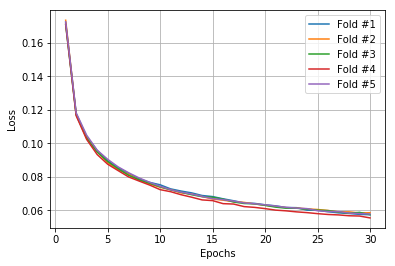

In [12]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("k-fold_loss_cnn_250ms_mani.eps")
plt.savefig("k-fold_loss_cnn_250ms_mani.png",dpi=150)
plt.show()

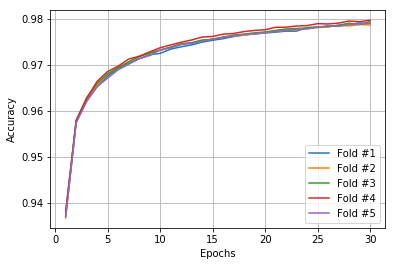

In [13]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("k-fold_acc_cnn_250ms_mani.eps",dpi=150)
plt.savefig('k-fold_acc_cnn_250ms_mani.png',dpi=150)
plt.show()

In [14]:
# Write the cross-validated prediction (from the last neural network)
import time
tic=time.time()
X_holdout = np.expand_dims(x_holdout, axis=2)
holdout_pred = model.predict(X_holdout)
toc=time.time()
print(str(1000*(toc-tic))+"ms")


13840.60788154602ms


In [15]:
holdout_pred1 = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare,holdout_pred1)
print("Holdout score (accuracy): {}".format(score))

Holdout score (accuracy): 0.9823719131314271


In [16]:
#X_holdout = np.expand_dims(x_holdout, axis=2)
#holdout_pred = model.predict(X_holdout)
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.0508298723748531


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [18]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

Confusion matrix, without normalization
[[57803     0     4     0]
 [    5 56117   695   612]
 [   15   275 56102  1248]
 [    6   377   824 56288]]


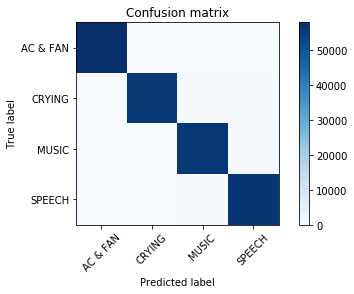

In [19]:

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_cnn_250ms_mani.png',dpi=150)
plt.savefig('cm_cnn_250ms_mani.eps',dpi=150)



In [20]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred1))  
print(classification_report(y_holdout_compare, holdout_pred1))

[[57803     0     4     0]
 [    5 56117   695   612]
 [   15   275 56102  1248]
 [    6   377   824 56288]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57807
           1       0.99      0.98      0.98     57429
           2       0.97      0.97      0.97     57640
           3       0.97      0.98      0.97     57495

   micro avg       0.98      0.98      0.98    230371
   macro avg       0.98      0.98      0.98    230371
weighted avg       0.98      0.98      0.98    230371



Confusion matrix, without normalization


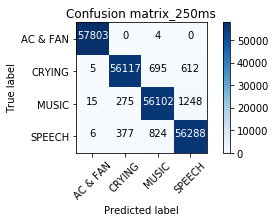

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_holdout_compare, holdout_pred1)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(5,3))
plot_confusion_matrix(cnf_matrix, classes=['AC & FAN', 'CRYING','MUSIC', 'SPEECH'],
                      title='Confusion matrix_250ms')

plt.savefig('cnn_confusiponmatrix_250ms.png')

In [22]:
[[B1,C1,M1,N1],[B2,C2,M2,N2],[B3,C3,M3,N3],
 [B4,C4,M4,N4]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  98.23719131314272
Precision:  98.23719131314272
Sensitivity/Recall:  98.23719131314272
Specificity:  98.23719131314272
Error Rate:  1.7628086868572868
F1-Score:  98.23719131314272


In [23]:
tic=time.time()
model.save('my_CNN_250ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

68.02153587341309ms


In [2]:
from keras.models import load_model
import time
tic=time.time()
my_model=load_model('my_CNN_250ms_mani.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")

1495.570182800293ms


In [3]:
df1=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/testing/cryingtest_250ms.csv")
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()
df1.shape

(143981, 13)

In [4]:
df2 = np.expand_dims(df1, axis=2)# We have to add 1dimension more for testing
df2.shape

(143981, 13, 1)

In [5]:
tic=time.time()
my_his1=my_model.predict(df2)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

7162.415266036987ms


In [6]:
test_pred1 = np.argmax(my_his1, axis=1)
test_pred1[150:380]
print(test_pred1.shape)

(143981,)


In [10]:
c =0
for i in  test_pred1:
    if i== 1:
         c += 1
    else:
        continue 
if c > test_pred1.size/2:
    print("The tested audio is crying")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is crying
Count is 95638


In [31]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of CRYING:',100*x)

Accuracy is for testing with new environment data of CRYING: 66.42404206110528


In [11]:
df3=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/testing/fanactest_250ms.csv")
df3.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df3.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.528069,24.999825,24.165910,12.674782,5.653173,7.214385,1.485795,8.789789,0.917394,6.621611,0.824606,1.492313,0.517273
1,-1.528101,25.323181,23.664504,13.609752,4.870912,8.285742,0.533066,9.859222,0.080067,7.785783,0.155050,2.907563,-0.180629
2,-1.662120,24.555502,27.534773,14.598178,3.038607,6.588641,-0.130420,10.277530,-1.088754,6.092309,-0.413334,3.373767,0.487513
3,-1.720085,25.011542,29.660180,15.009168,1.298934,6.233285,-0.534297,11.863069,-1.174127,5.151966,-0.809689,3.493457,0.284411
4,-1.617799,25.549126,29.992581,15.009510,1.345690,7.089722,-0.331442,12.892941,-1.058761,6.255099,-0.216735,3.898345,0.023903


In [12]:
df4= np.expand_dims(df3, axis=2)# We have to add 1dimension more for testing
df4.shape

(143981, 13, 1)

In [13]:
tic=time.time()
my_his2=my_model.predict(df4)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

6893.26024055481ms


In [14]:
test_pred2 = np.argmax(my_his2, axis=1)
test_pred2[150:380]
print(test_pred2.shape)

(143981,)


In [18]:
c =0
for i in  test_pred2:
    if i== 0:
         c += 1
    else:
        continue 
if c > test_pred2.size/2:
    print("The tested audio is ac&fan")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is ac&fan
Count is 92492


In [37]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of ac&fan:',100*x)

Accuracy is for testing with new environment data of ac&fan: 64.23903153888361


In [19]:
df7=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/testing/musictest_250ms.csv")
df7.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df7.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-1.134541,-20.487844,-13.760015,3.246202,-32.597762,17.587059,-33.695512,2.830326,1.710832,-8.700560,18.110851,-2.603898,8.202629
1,-1.179964,-20.141188,-13.259199,3.242886,-32.428630,17.984391,-33.479255,2.263041,2.143565,-7.287058,18.174474,-2.908441,8.665985
2,-1.215126,-20.138310,-14.068503,3.102818,-33.122855,16.316123,-33.694333,2.081717,1.175639,-8.196891,17.370584,-4.274559,8.534495
3,-1.253640,-18.963374,-15.976393,0.004072,-34.315426,18.325803,-26.561250,6.338449,-3.368631,-13.922574,14.799424,-3.884607,15.216122
4,-1.193043,-19.310359,-18.713185,0.081081,-36.636470,16.946856,-19.715096,5.869658,-8.002131,-13.980317,16.757785,-2.942272,18.947688


In [20]:
df8 = np.expand_dims(df7, axis=2)# We have to add 1dimension more for testing
df8.shape

(143981, 13, 1)

In [21]:
tic=time.time()
my_his4=my_model.predict(df8)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

6729.68602180481ms


In [22]:
test_pred4 = np.argmax(my_his4, axis=1)
test_pred4[150:380]
print(test_pred4.shape)

(143981,)


In [26]:
c =0
for i in  test_pred4:
    if i== 2:
         c += 1
    else:
        continue 
if c > test_pred4.size/2:
    print("The tested audio is music")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is music
Count is 118836


In [43]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of music:',100*x)

Accuracy is for testing with new environment data of music: 82.53589015217285


In [27]:
df9=pd.read_csv("/home/bsplab/Desktop/manikanta/16khz_data/NEWFRAME_SHIFTING_DATA/CNN+MFCC_newshifting/250ms/testing/speechtest_250.csv")
df9.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df9.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-0.289875,2.258400,-41.914954,-4.024645,-7.902380,-19.871502,-13.919534,-1.636795,-0.808601,-35.921280,-5.589058,-10.004502,-11.870955
1,-0.932115,4.651622,-35.209450,-1.746077,-7.467012,-22.130116,-17.880100,-6.702932,-6.508224,-35.590233,-3.761109,-10.575987,-12.329757
2,-2.332744,9.115780,-20.119954,-1.832084,-8.780608,-25.854842,-24.363579,-2.415750,-7.440496,-37.154831,-1.612570,-15.719020,-8.436165
3,-3.042283,11.471622,-12.403395,6.392536,-20.568994,-21.510535,-38.058389,-11.107811,-4.817670,-23.795946,-9.637637,-25.883666,-7.959838
4,-3.085255,13.708118,-16.291657,-4.319005,-20.464945,-8.739739,-31.295461,-25.391509,-20.898807,-15.938178,-21.201083,-23.255454,-11.559138


In [28]:
df10 = np.expand_dims(df9, axis=2)# We have to add 1dimension more for testing
df10.shape

(143981, 13, 1)

In [29]:
tic=time.time()
my_his5=my_model.predict(df10)
toc=time.time()
print(str(1000*(toc-tic))+"ms")

6989.554882049561ms


In [30]:
test_pred5 = np.argmax(my_his5, axis=1)
test_pred5[150:380]
print(test_pred5.shape)

(143981,)


In [34]:
c =0
for i in  test_pred5:
    if i== 3:
         c += 1
    else:
        continue 
if c > test_pred5.size/2:
    print("The tested audio is speech")
else:
    print("Error")
       
        
print("Count is " + str(c))

The tested audio is speech
Count is 132977


In [51]:
x=c/test_pred1.size
print('Accuracy is for testing with new environment data of speech:',100*x)

Accuracy is for testing with new environment data of speech: 92.35732492481647
